Real Data PCA Shape: (1348, 10)
Synthetic Data PCA Shape: (1348, 10)
Combined Data Shape: (2696, 10)
Covariance matrix shape: (10, 10)
Covariance matrix has been regularized.
Mahalanobis Distance between Real and Synthetic Data: 0.6626


/Users/mohtim/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/mohtim/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


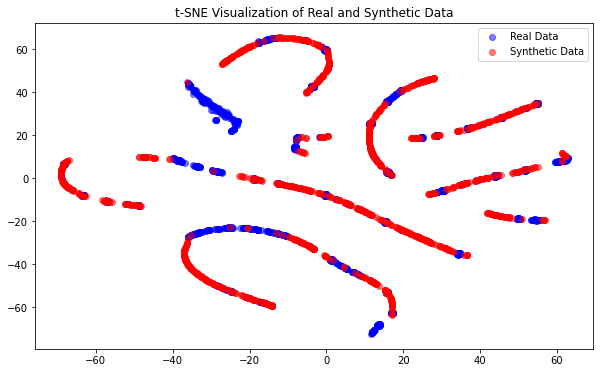

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from scipy.linalg import inv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you already loaded your datasets
real_data = pd.read_csv("Data/patient_features_early_stage.csv")
synthetic_data = pd.read_csv("synthetic_relapse_data_gaussian.csv")

# Step 1: Handle missing values (replace with mean for numerical and mode for categorical)
def fill_missing_values(real_data, synthetic_data):
    real_data.fillna(real_data.mean(numeric_only=True), inplace=True)
    synthetic_data.fillna(synthetic_data.mean(numeric_only=True), inplace=True)
    
    real_data.fillna(real_data.mode().iloc[0], inplace=True)
    synthetic_data.fillna(synthetic_data.mode().iloc[0], inplace=True)

fill_missing_values(real_data, synthetic_data)

# Step 2: One-Hot Encode Categorical Variables
def encode_categorical_data(real_data, synthetic_data):
    categorical_columns = real_data.select_dtypes(include=['object']).columns.tolist()
    
    encoder = OneHotEncoder(sparse=False, drop='first')  
    real_encoded = encoder.fit_transform(real_data[categorical_columns])
    synthetic_encoded = encoder.transform(synthetic_data[categorical_columns])

    real_encoded_df = pd.DataFrame(real_encoded, columns=encoder.get_feature_names_out(categorical_columns))
    synthetic_encoded_df = pd.DataFrame(synthetic_encoded, columns=encoder.get_feature_names_out(categorical_columns))

    real_data_encoded = pd.concat([real_data.drop(columns=categorical_columns), real_encoded_df], axis=1)
    synthetic_data_encoded = pd.concat([synthetic_data.drop(columns=categorical_columns), synthetic_encoded_df], axis=1)
    
    return real_data_encoded, synthetic_data_encoded

real_data_encoded, synthetic_data_encoded = encode_categorical_data(real_data, synthetic_data)

# Ensure all data is numeric and has no NaN values
real_data_encoded = real_data_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
synthetic_data_encoded = synthetic_data_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert booleans to 0/1 and ensure data is float
real_data_encoded = real_data_encoded.astype(float)
synthetic_data_encoded = synthetic_data_encoded.astype(float)

### Solution 1: Remove Low-Variance Features
def remove_low_variance_features(real_data, synthetic_data, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    real_data_reduced = selector.fit_transform(real_data)
    synthetic_data_reduced = selector.transform(synthetic_data)
    return real_data_reduced, synthetic_data_reduced

# Choose whether to apply low-variance feature removal (set to True to apply)
apply_low_variance = True
if apply_low_variance:
    real_data_encoded, synthetic_data_encoded = remove_low_variance_features(real_data_encoded, synthetic_data_encoded, threshold=0.01)

### Solution 2: PCA for Dimensionality Reduction
def apply_pca(real_data, synthetic_data, n_components=10):
    # Use a fixed number of components to avoid single dimension reduction
    pca = PCA(n_components=n_components)
    real_data_pca = pca.fit_transform(real_data)
    synthetic_data_pca = pca.transform(synthetic_data)
    
    print(f"Real Data PCA Shape: {real_data_pca.shape}")
    print(f"Synthetic Data PCA Shape: {synthetic_data_pca.shape}")
    
    return real_data_pca, synthetic_data_pca

# Choose whether to apply PCA (set to True to apply)
apply_pca_dimensionality_reduction = True
if apply_pca_dimensionality_reduction:
    real_data_encoded, synthetic_data_encoded = apply_pca(real_data_encoded, synthetic_data_encoded, n_components=10)

### Solution 3: Regularize Covariance Matrix
def regularize_cov_matrix(cov_matrix, lambda_val=1e-5):
    return cov_matrix + lambda_val * np.eye(cov_matrix.shape[0])

def compute_mahalanobis_distance(real_data_encoded, synthetic_data_encoded, regularize=False, lambda_val=1e-5):
    combined_data = np.vstack([real_data_encoded, synthetic_data_encoded])
    
    print(f"Combined Data Shape: {combined_data.shape}")
    
    if combined_data.shape[1] == 1:
        print("Warning: Covariance matrix cannot be computed for a single feature.")
        return
    
    try:
        cov_matrix = np.cov(combined_data, rowvar=False)
        print(f"Covariance matrix shape: {cov_matrix.shape}")
        
        if regularize:
            cov_matrix = regularize_cov_matrix(cov_matrix, lambda_val)
            print("Covariance matrix has been regularized.")
        
    except Exception as e:
        print(f"Error computing covariance matrix: {e}")
        return
    
    if np.linalg.det(cov_matrix) == 0:
        print("Warning: Covariance matrix is singular and cannot be inverted.")
        return
    
    inv_cov_matrix = inv(cov_matrix)
    
    mean_real = np.mean(real_data_encoded, axis=0)
    mean_synthetic = np.mean(synthetic_data_encoded, axis=0)
    
    mean_diff = mean_real - mean_synthetic
    dist = np.sqrt(np.dot(np.dot(mean_diff, inv_cov_matrix), mean_diff.T))
    
    print(f"Mahalanobis Distance between Real and Synthetic Data: {dist:.4f}")

# Choose whether to apply regularization to the covariance matrix (set to True to apply)
apply_regularization = True
compute_mahalanobis_distance(real_data_encoded, synthetic_data_encoded, regularize=apply_regularization, lambda_val=1e-5)

### t-SNE Visualization
def plot_tsne(real_data_encoded, synthetic_data_encoded):
    combined_data = np.vstack([real_data_encoded, synthetic_data_encoded])
    
    labels = np.array([0] * len(real_data_encoded) + [1] * len(synthetic_data_encoded))
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(combined_data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], label='Real Data', alpha=0.5, color='blue')
    plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], label='Synthetic Data', alpha=0.5, color='red')
    plt.title('t-SNE Visualization of Real and Synthetic Data')
    plt.legend()
    plt.show()

plot_tsne(real_data_encoded, synthetic_data_encoded)
